# Time Series Forecasting with LSTMs for Number of Heart Failure Events using in Python 

> This tutorial is NOT trying to build a model that predicts the Covid-19 outbreak/pandemic in the best way possible. This is an example of how you can use Recurrent Neural Networks on some real-world Time Series data with PyTorch. Hopefully, there are much better models that predict the number of daily confirmed cases.

Time series data captures a series of data points recorded at (usually) regular intervals. Some common examples include daily weather temperature, stock prices, and the number of sales a company makes.

Many classical methods (e.g. ARIMA) try to deal with Time Series data with varying success (not to say they are bad at it). In the last couple of years, [Long Short Term Memory Networks (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory) models have become a very useful method when dealing with those types of data.

Recurrent Neural Networks (LSTMs are one type of those) are very good at processing sequences of data. They can "recall" patterns in the data that are very far into the past (or future). In this tutorial, you're going to learn how to use LSTMs to predict future Coronavirus cases based on real-world data.

- [Run the complete notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1nQYJq1f7f4R0yeZOzQ9rBKgk00AfLoS0)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

In [109]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Daily Cases Dataset

The data is provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) and contains the number of reported daily cases by country. [The dataset is available on GitHub](https://github.com/CSSEGISandData/COVID-19) and is updated regularly.

We're going to take the Time Series data only for confirmed cases (number of deaths and recovered cases are also available):

In [110]:
#import io
#from google.colab import files
#files.upload()

Or you can take the same dataset that I've used for this tutorial (the data snapshot is from 3 March 2020):

## Data exploration

Let's load the data and have a peek:

In [111]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Two things to note here:

- The data contains a province, country, latitude, and longitude. We won't be needing those.
- The number of cases is cumulative. We'll undo the accumulation.

Let's start by getting rid of the first four columns:

In [112]:

#df = df.iloc[:, 4:]


In [113]:
df.head()


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Let's check for missing values:

In [114]:
#df.isnull().sum().sum()

In [115]:
#country=df.sum(axis=0)
#np.shape(country)
#print(country[92:93])
#print(country[100:150])

Everything seems to be in place. Let's sum all rows, so we get the cumulative daily cases:

In [116]:
#daily_cases = df.sum(axis=0)
#daily_cases.index = pd.to_datetime(daily_cases.index)
#print(daily_cases)

In [117]:
#plt.plot(daily_cases)
#plt.title("Cumulative daily cases");
#plt.xlabel('Date')
#plt.ylabel('Cumulative Daily Cases')

In [118]:
ages=df.iloc[:,0:1]
ages.head()
age=ages.to_numpy()
#print(age)
times=df.iloc[:,11:12]
time=times.to_numpy()
#print(time)
age_sort=sorted(age)
print(age_sort)
count=np.zeros(len(age), dtype = int)
time_blank=np.zeros(len(age), dtype = int)
test=39
t=0
age_wise_sum=np.zeros(len(age), dtype = int)
for i in range(len(age)):
    test=test+1
    cnt=0
    summ=0
    for j in range(len(time)):
        if (age[j]==test):
            cnt=cnt+1
            time_blank[t]=time[j]
            t=t+1
            summ=summ+time[j]
    count[i]=cnt
    age_wise_sum[i]=summ
count= [ count[i] for i in range(len(age)) if i <(max(age_sort)-min(age_sort)+1)]
age_wise_sum= [ age_wise_sum[i] for i in range(len(age)) if i <(max(age_sort)-min(age_sort)+1)]
#print((age_wise_sum))
all_age=np.zeros(int((max(age_sort))-(min(age_sort))+1))
all_age=[ j+min(age_sort) for j in range(len(all_age))]
print((all_age))


[array([40.]), array([40.]), array([40.]), array([40.]), array([40.]), array([40.]), array([40.]), array([41.]), array([42.]), array([42.]), array([42.]), array([42.]), array([42.]), array([42.]), array([42.]), array([43.]), array([44.]), array([44.]), array([45.]), array([45.]), array([45.]), array([45.]), array([45.]), array([45.]), array([45.]), array([45.]), array([45.]), array([45.]), array([45.]), array([45.]), array([45.]), array([45.]), array([45.]), array([45.]), array([45.]), array([45.]), array([45.]), array([46.]), array([46.]), array([46.]), array([47.]), array([48.]), array([48.]), array([49.]), array([49.]), array([49.]), array([49.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array([50.]), array

C:\Users\ersha\AppData\Local\Temp\ipykernel_10440\2073142734.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time_blank[t]=time[j]
C:\Users\ersha\AppData\Local\Temp\ipykernel_10440\2073142734.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_wise_sum[i]=summ


[array([40.]), array([41.]), array([42.]), array([43.]), array([44.]), array([45.]), array([46.]), array([47.]), array([48.]), array([49.]), array([50.]), array([51.]), array([52.]), array([53.]), array([54.]), array([55.]), array([56.]), array([57.]), array([58.]), array([59.]), array([60.]), array([61.]), array([62.]), array([63.]), array([64.]), array([65.]), array([66.]), array([67.]), array([68.]), array([69.]), array([70.]), array([71.]), array([72.]), array([73.]), array([74.]), array([75.]), array([76.]), array([77.]), array([78.]), array([79.]), array([80.]), array([81.]), array([82.]), array([83.]), array([84.]), array([85.]), array([86.]), array([87.]), array([88.]), array([89.]), array([90.]), array([91.]), array([92.]), array([93.]), array([94.]), array([95.])]


C:\Users\ersha\AppData\Local\Temp\ipykernel_10440\2073142734.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_age=np.zeros(int((max(age_sort))-(min(age_sort))+1))


We'll undo the accumulation by subtracting the current value from the previous. We'll preserve the first value of the sequence:

In [119]:
#daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
#daily_cases.head()

Text(0, 0.5, 'Number of Total Heart Failure')

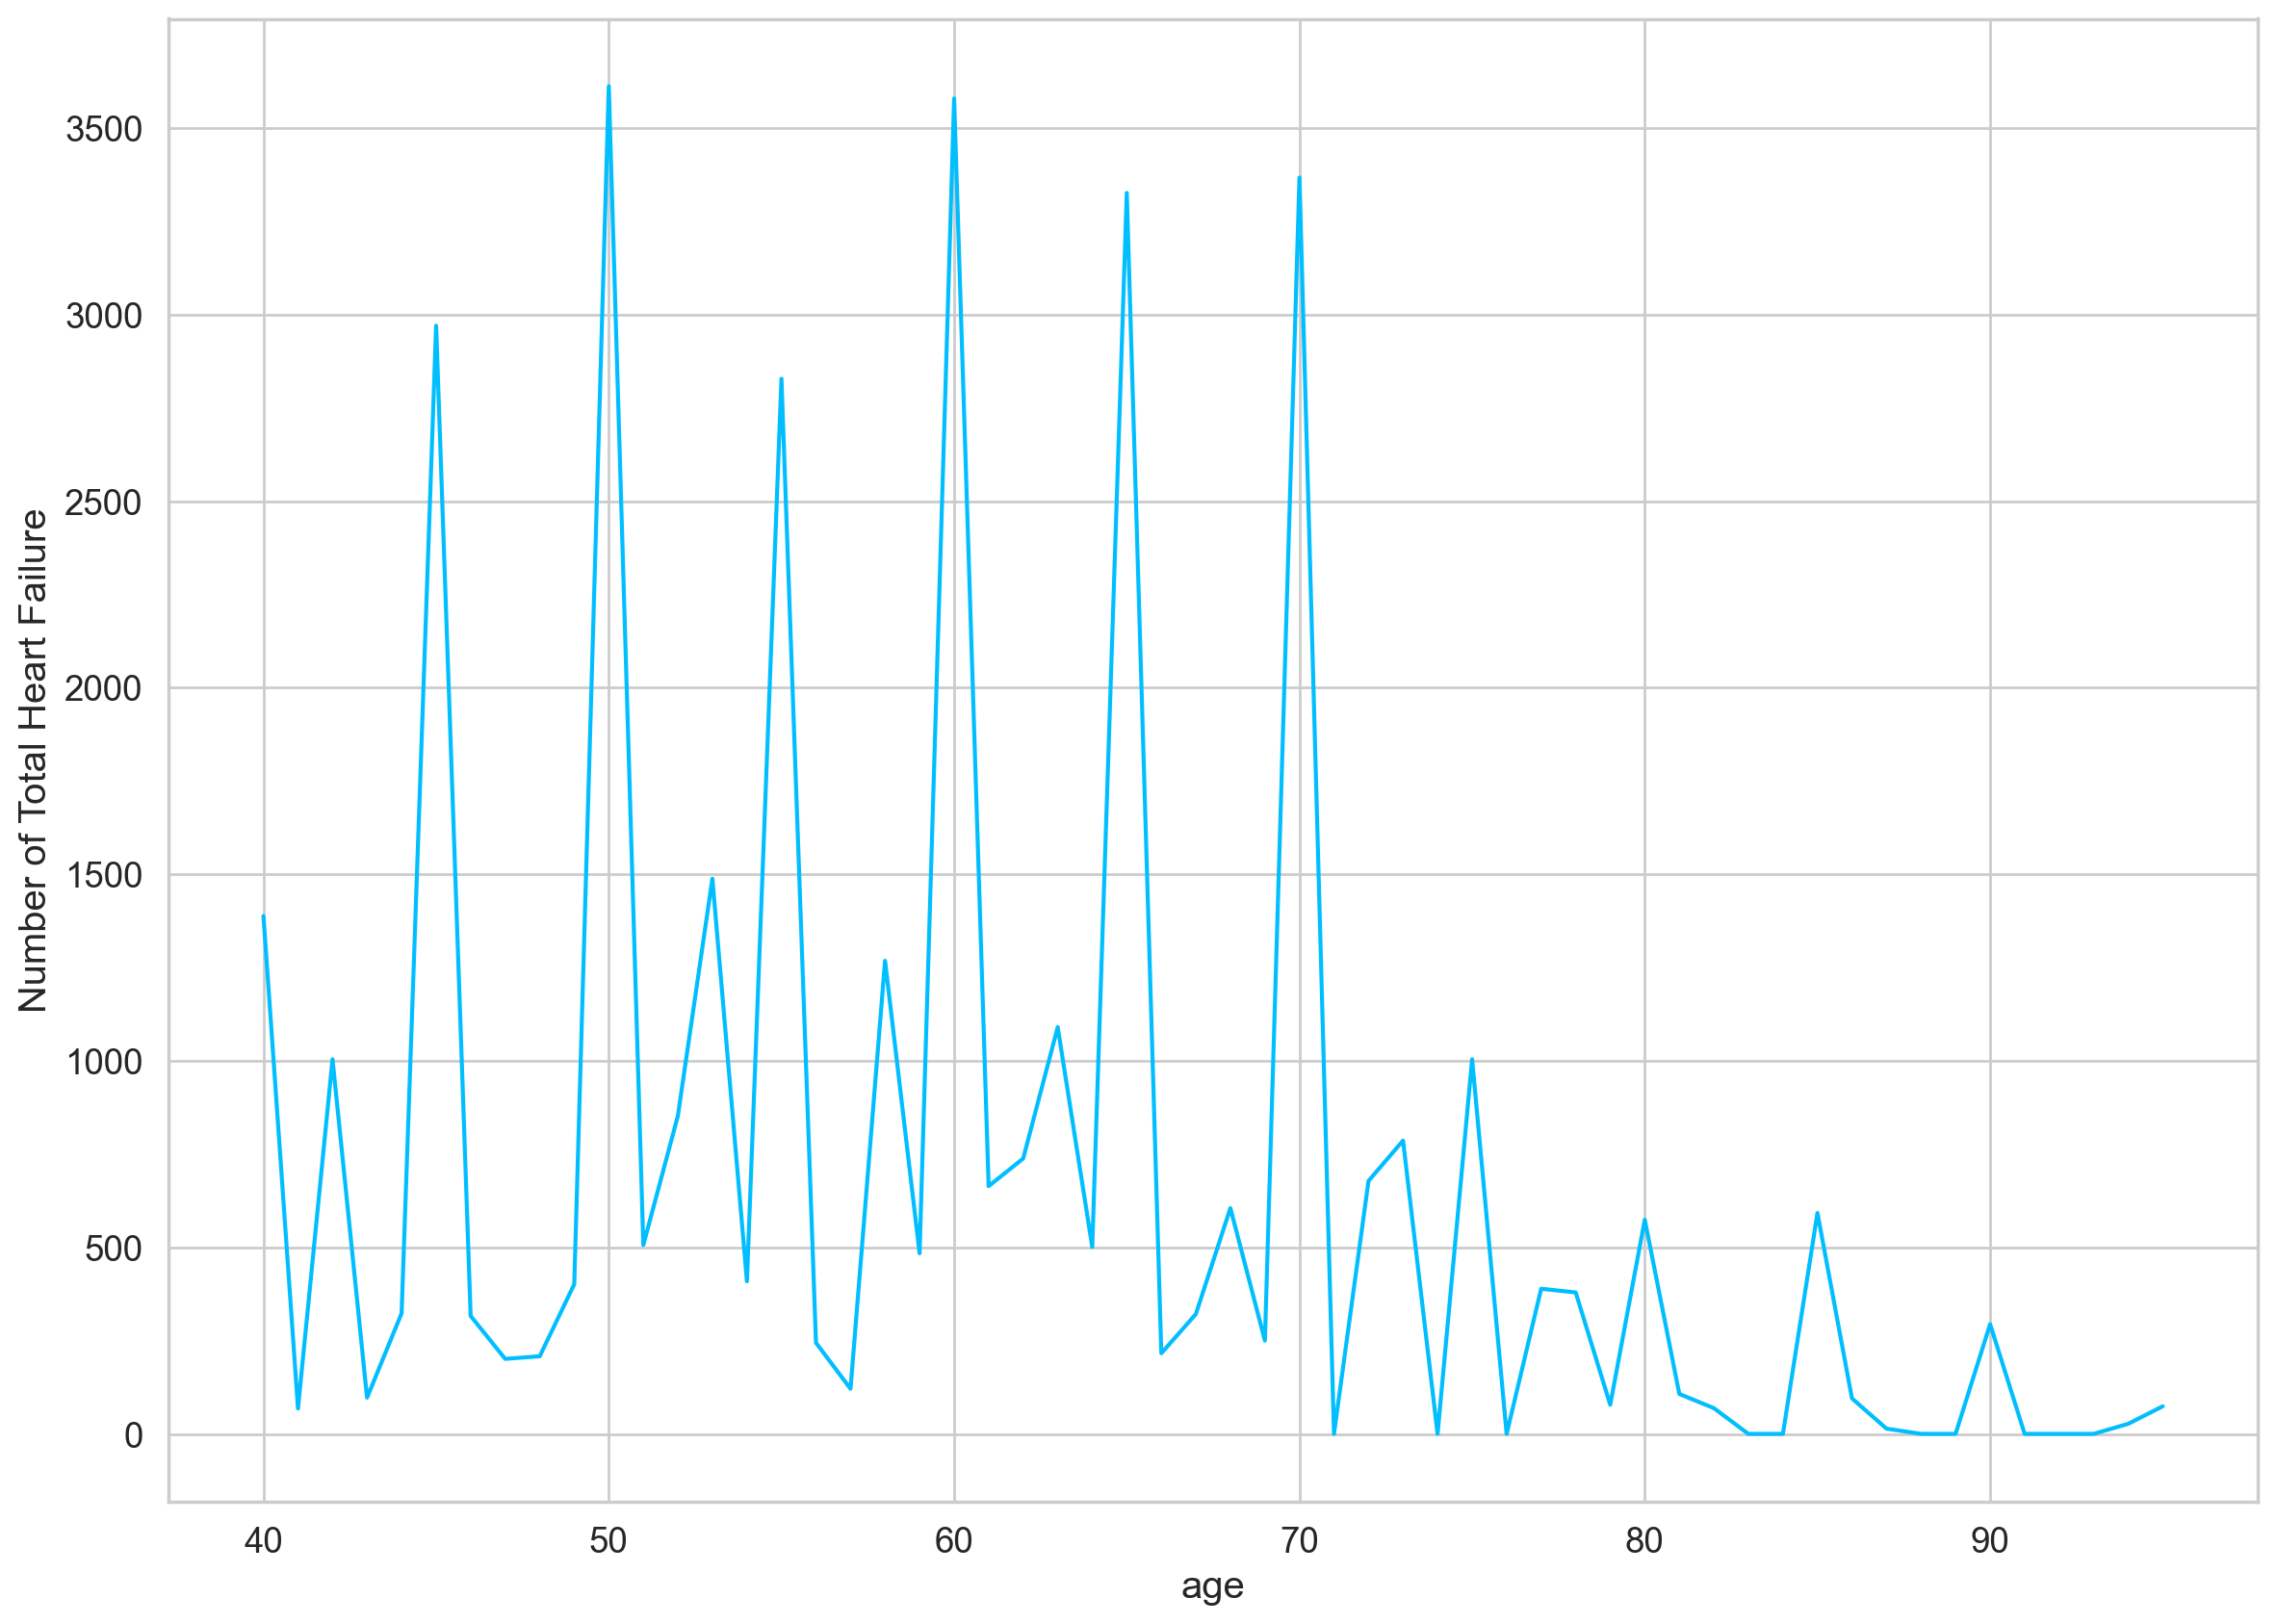

In [120]:
plt.plot(all_age,age_wise_sum)
#plt.title("Number of Total Heart Failure With Respect to Age");
plt.xlabel('age')
plt.ylabel('Number of Total Heart Failure')

The huge spike (in the middle) is mostly due to a change of criteria for testing patients in China. This will certainly be a challenge for our model.

Let's check the amount of data we have:

In [121]:
#daily_cases.shape

Unfortunately, we have data for only 41 days. Let's see what we can do with it!

## Preprocessing

We'll reserve the first 27 days for training and use the rest for testing:

In [122]:
test_data_size = 24

train_data = age_wise_sum[:-test_data_size]
test_data = age_wise_sum[-test_data_size:]


print(train_data)

[1388, 68, 1004, 97, 323, 2970, 316, 201, 208, 401, 3612, 506, 852, 1488, 409, 2828, 244, 121, 1268, 484, 3579, 664, 738, 1090, 501, 3326, 216, 321, 605, 250, 3367, 0]


We have to scale the data (values will be between 0 and 1) if we want to increase the training speed and performance of the model. We'll use the `MinMaxScaler` from scikit-learn:

In [123]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

Currently, we have a big sequence of daily cases. We'll convert it into smaller ones:

In [124]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [125]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


print(len(y_test))
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


18


Each training example contains a sequence of 5 data points of history and a label for the real value that our model needs to predict. Let's dive in:

In [126]:
X_train.shape

torch.Size([26, 5, 1])

In [127]:
X_train[:2]

tensor([[[0.3843],
         [0.0188],
         [0.2780],
         [0.0269],
         [0.0894]],

        [[0.0188],
         [0.2780],
         [0.0269],
         [0.0894],
         [0.8223]]])

In [128]:
y_train.shape

torch.Size([26, 1])

In [129]:
y_train[:2]

tensor([[0.8223],
        [0.0875]])

In [130]:
train_data[:10]

array([[0.38427464],
       [0.01882614],
       [0.27796235],
       [0.02685493],
       [0.08942414],
       [0.82225914],
       [0.08748616],
       [0.05564784],
       [0.05758583],
       [0.11101883]])

## Building a model

We'll encapsulate the complexity of our model into a class that extends from `torch.nn.Module`:

In [139]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

Our `CoronaVirusPredictor` contains 3 methods:
- constructor - initialize all helper data and create the layers
- `reset_hidden_state` - we'll use a stateless LSTM, so we need to reset the state after each example
- `forward` - get the sequences, pass all of them through the LSTM layer, at once. We take the output of the last time step and pass it through our linear layer to get the prediction.

## Training

Let's build a helper function for the training of our model (we'll reuse it later):

In [140]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.RMSprop(model.parameters(), lr=1e-2)
  num_epochs =50

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

Note that the hidden state is reset at the start of each epoch. We don't use batches of data our model sees every example at once. We'll use mean squared error to measure our training and test error. We'll record both. 

Let's create an instance of our model and train it:

In [141]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 5.141986846923828 test loss: 0.05695644021034241
Epoch 10 train loss: 2.9294018745422363 test loss: 1.3642724752426147
Epoch 20 train loss: 2.9078352451324463 test loss: 1.6400704383850098
Epoch 30 train loss: 2.8867573738098145 test loss: 1.5530941486358643
Epoch 40 train loss: 2.871397018432617 test loss: 1.535125732421875


Let's have a look at the train and test loss:

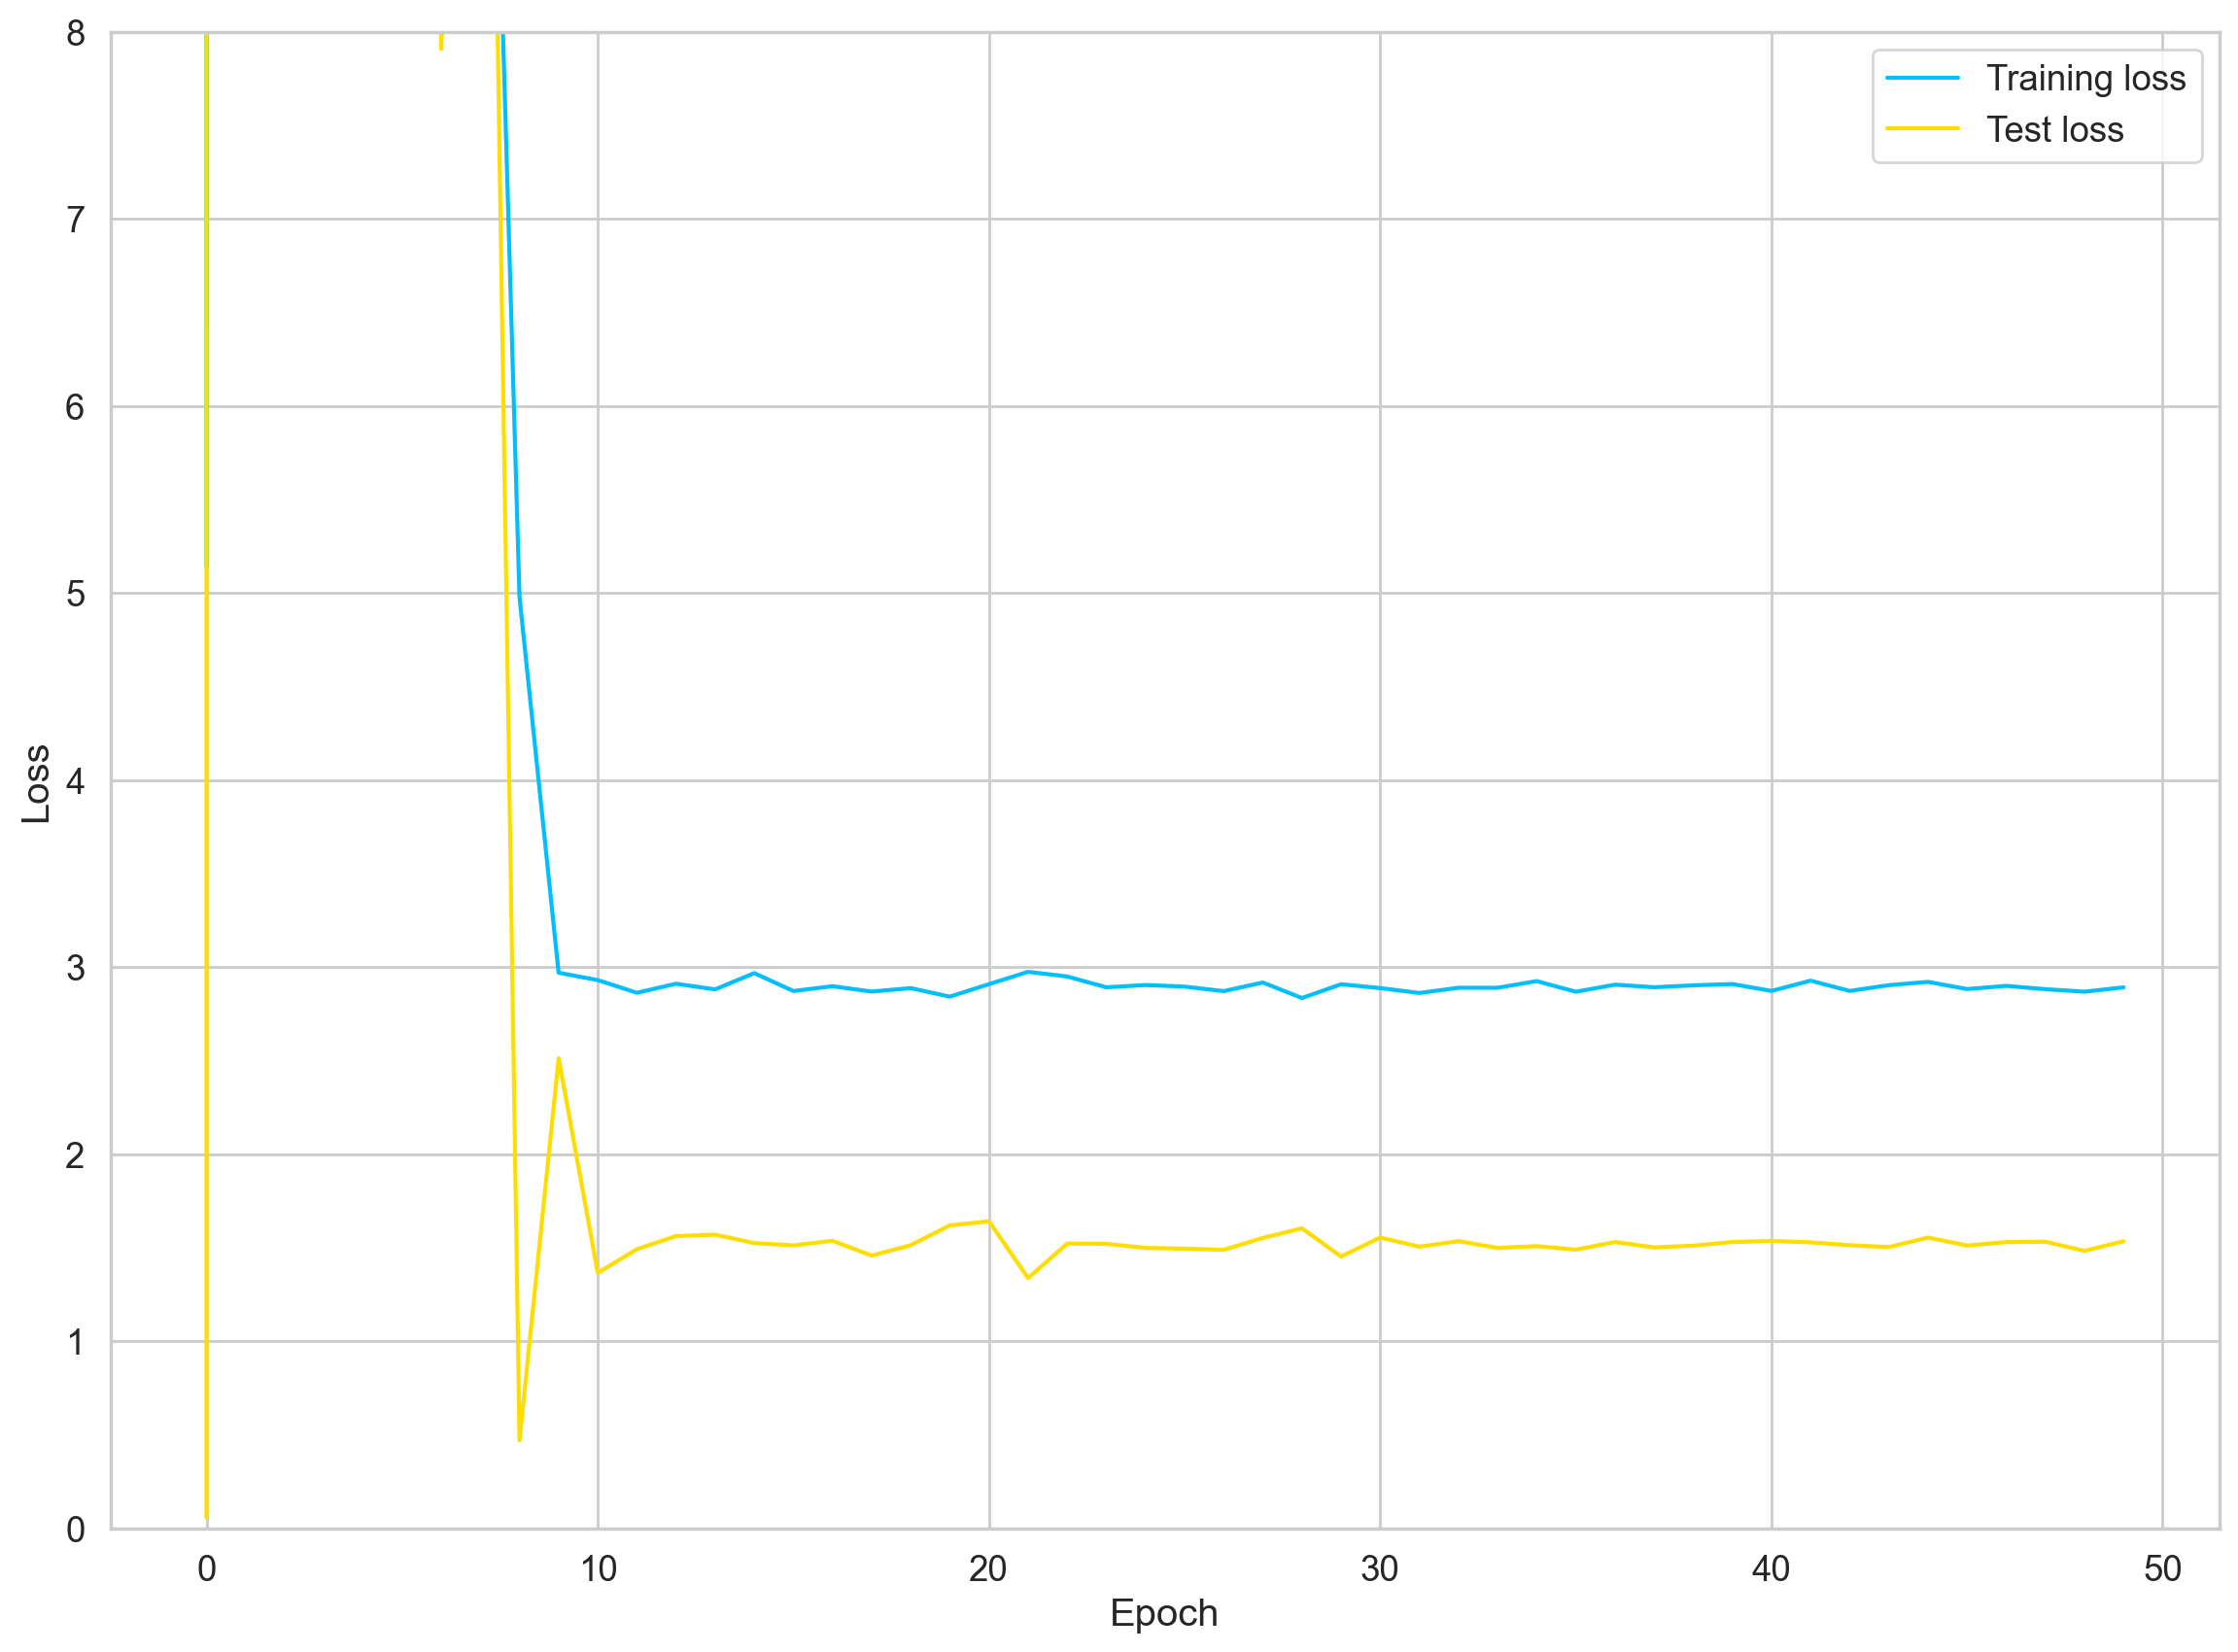

In [142]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 8))
plt.legend();
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('hearstroke_based_on_ejection_fraction.png', bbox_inches='tight')

Our model's performance doesn't improve after 15 epochs or so. Recall that we have very little data. Maybe we shouldn't trust our model that much?

## Predicting daily cases

Our model can (due to the way we've trained it) predict only a single day in the future. We'll employ a simple strategy to overcome this limitation. Use predicted values as input for predicting the next days:

In [143]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

We have to reverse the scaling of the test data and the model predictions:

In [144]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()
print(true_cases)
print((predicted_cases))

[389. 379.  78. 574. 107.  69.   0.   0. 592.  95.  14.   0.   0. 294.
   0.   0.   0.  27.]
[1180.48293972 1180.31339729 1180.3265301  1180.33234298 1180.33578765
 1180.33686411 1180.33664882 1180.33535707 1180.33341944 1180.33105123
 1180.32846773 1180.32599187 1180.32319307 1180.32060957 1180.31770313
 1180.31511962 1180.31253612 1180.30973732]


Let's look at the results:

[False False False False False False False False False False False False
 False False False False False False]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
Confusion matrix : 
 [[ 0  0]
 [18  0]]


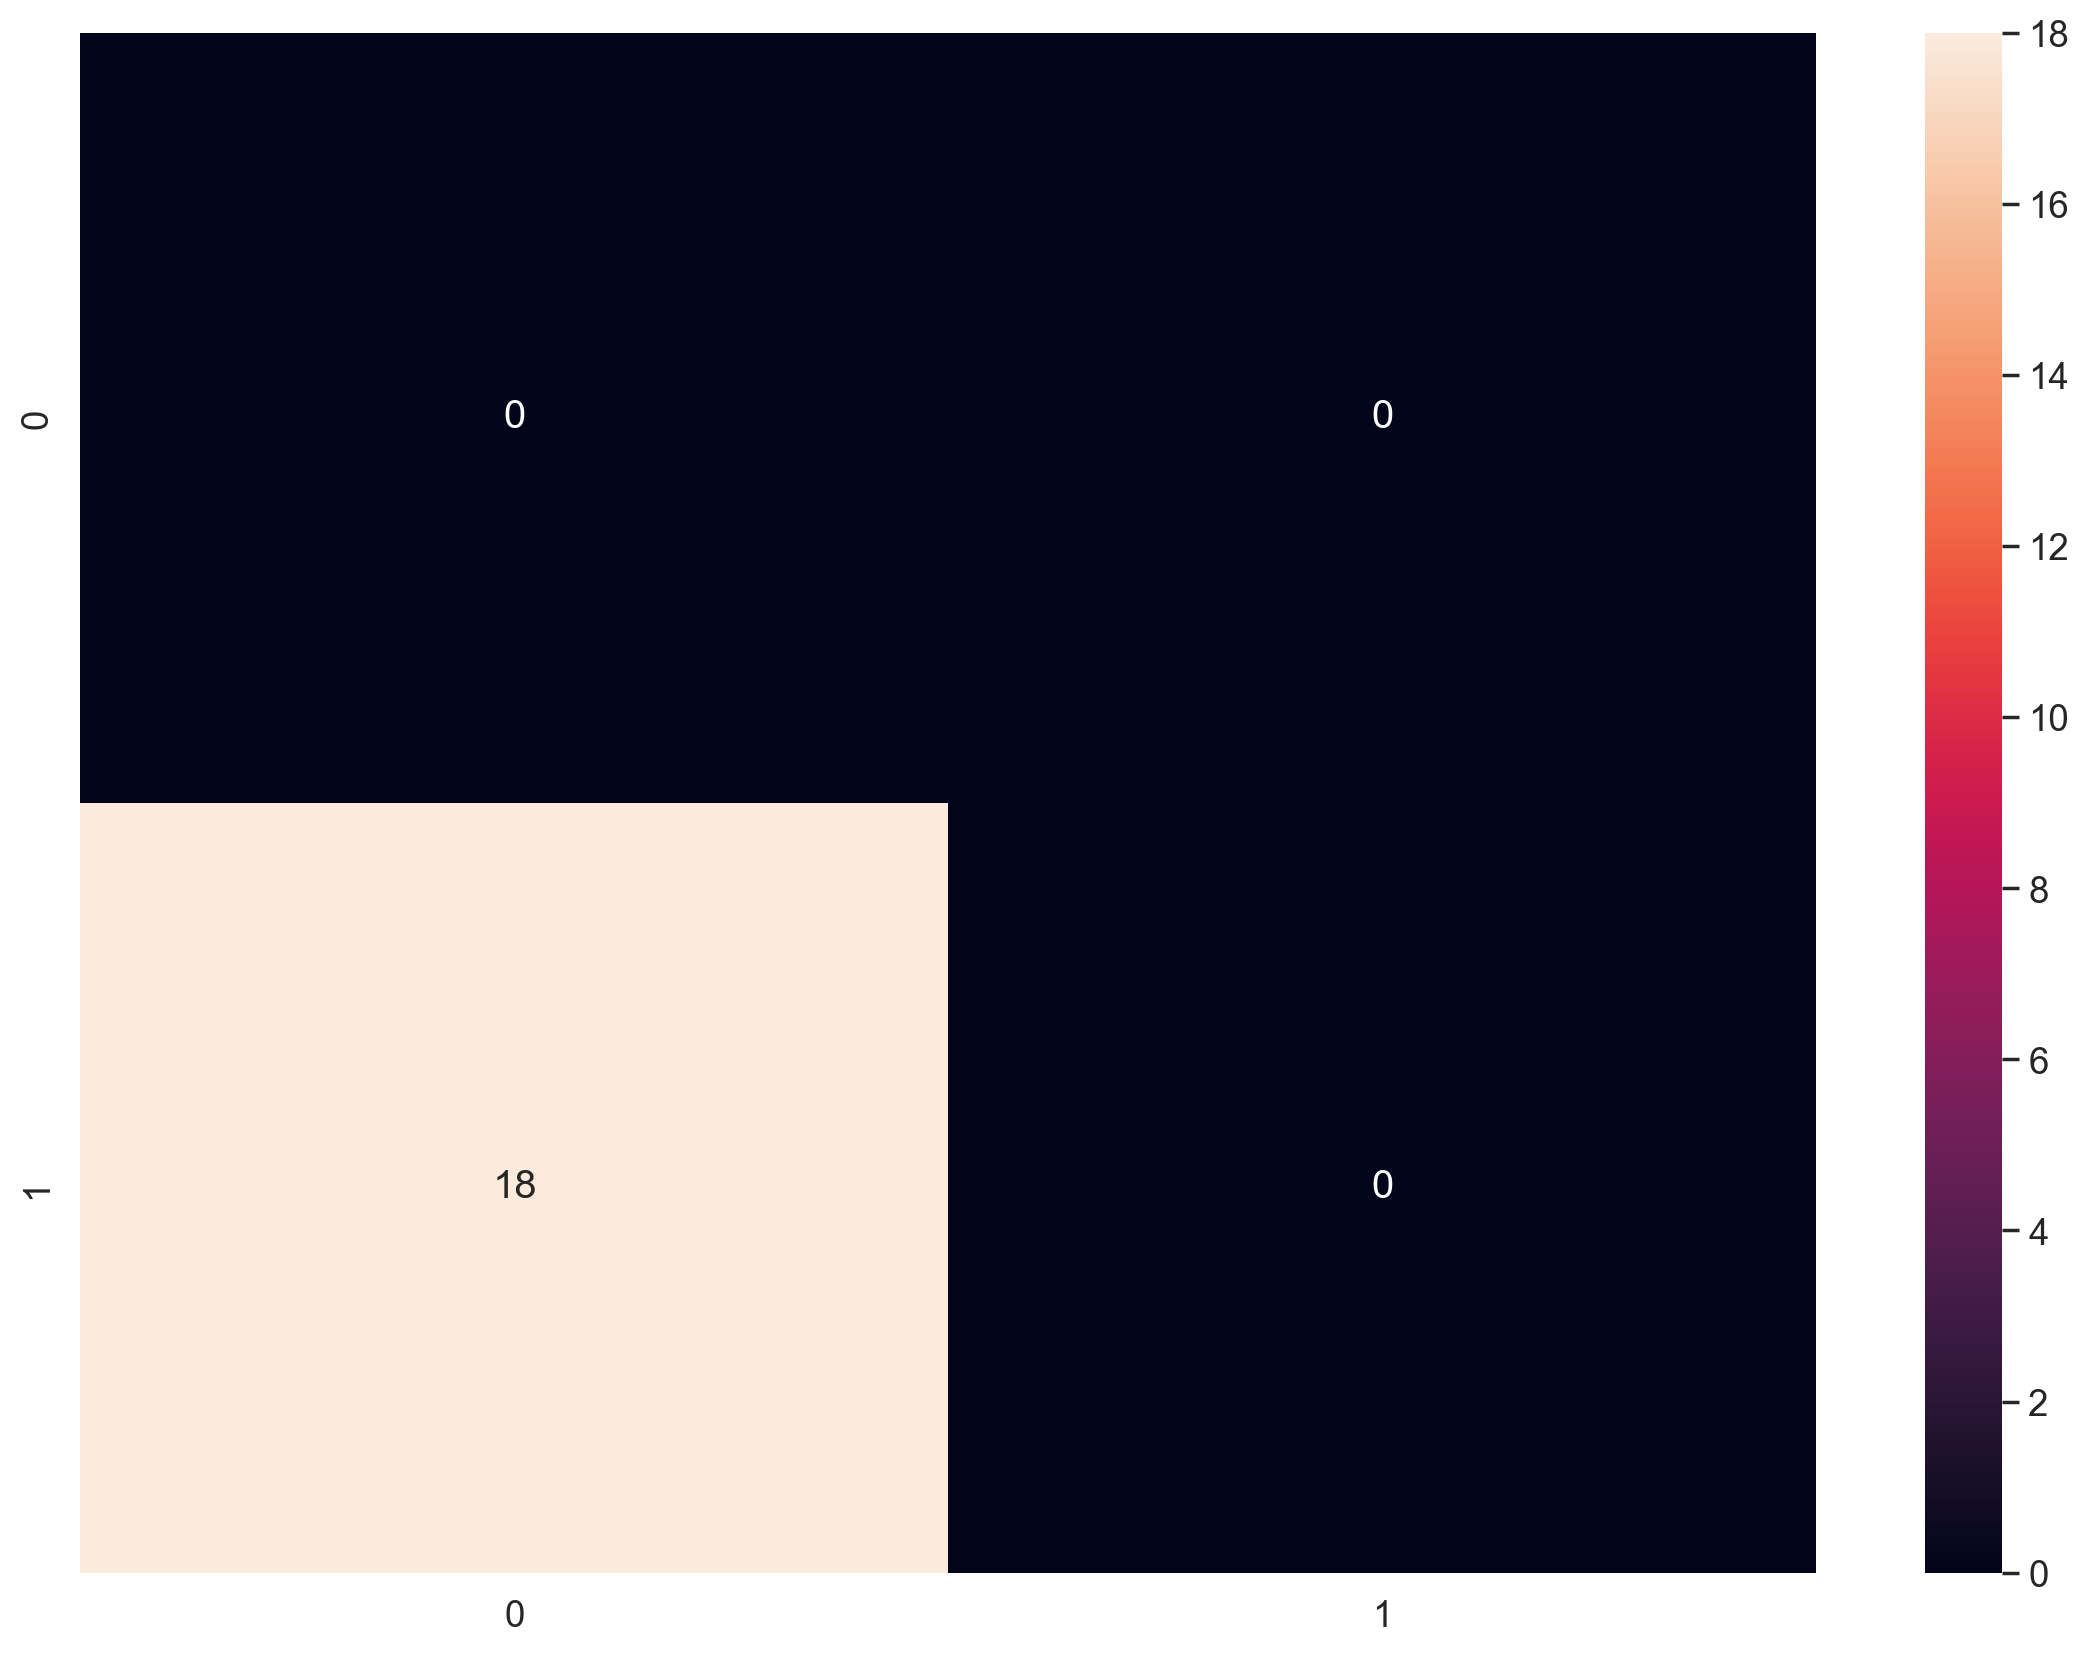

In [145]:
from sklearn.metrics import confusion_matrix

bin_true_cases=(true_cases<=600)
bin_predicted_cases=(predicted_cases<=600)
print(bin_predicted_cases)
print(bin_true_cases)
matrix = confusion_matrix(bin_true_cases,bin_predicted_cases)
print('Confusion matrix : \n',matrix)
sns.heatmap(matrix, annot=True)
plt.show()

Text(0, 0.5, 'Total number of heart failure')

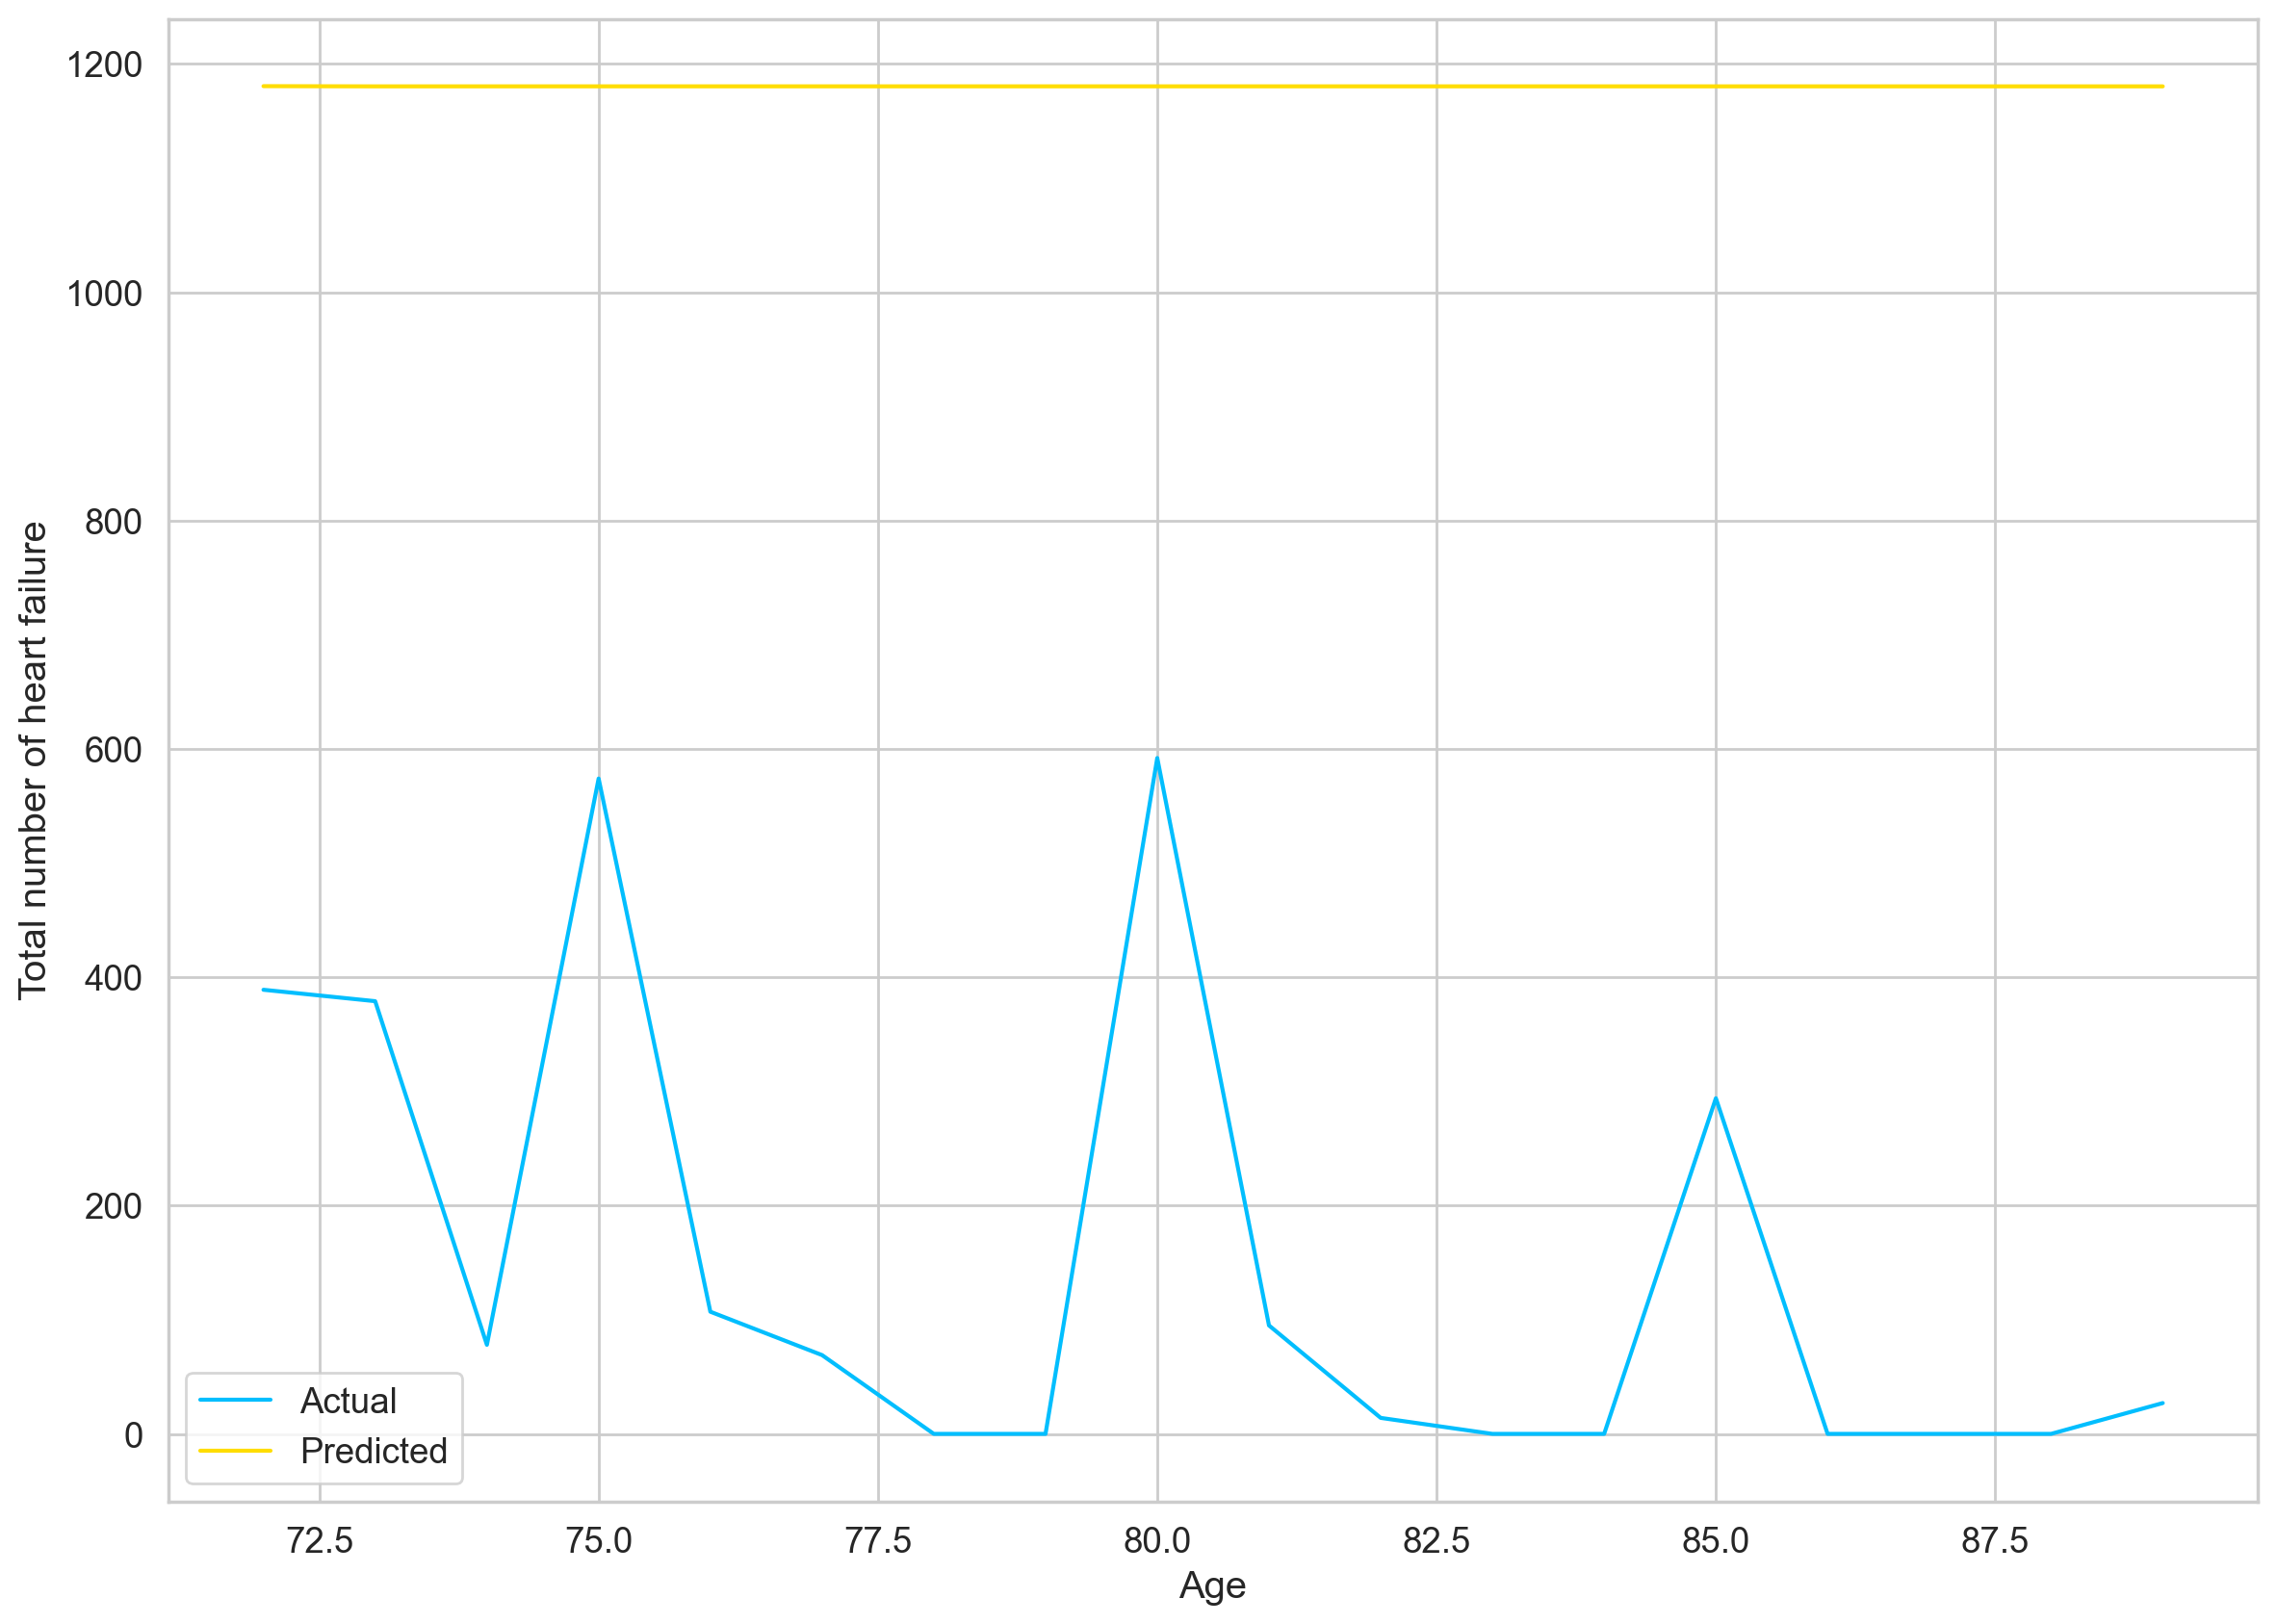

In [146]:
#plt.plot(
 # all_age[:len(train_data)], 
#  scaler.inverse_transform(train_data).flatten(),
 # label='Historical Number of Total Heart Failure'
#)

plt.plot(
  all_age[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Actual'
)

plt.plot(
  all_age[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted'
)

plt.legend()
plt.xlabel("Age")
plt.ylabel("Total number of heart failure")

As expected, our model doesn't perform very well. That said, the predictions seem to be in the right ballpark (probably due to using the last data point as a strong predictor for the next).

## Use all data for training

Now, we'll use all available data to train the same model:

In [147]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(age_wise_sum, axis=1))

all_data = scaler.transform(np.expand_dims(age_wise_sum, axis=1))

all_data.shape

(56, 1)

The preprocessing and training steps are the same:

In [148]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 5.326623916625977
Epoch 10 train loss: 2.900702953338623
Epoch 20 train loss: 2.895223617553711
Epoch 30 train loss: 2.894826889038086
Epoch 40 train loss: 2.894758701324463


## Predicting future cases

We'll use our "fully trained" model to predict the confirmed cases for 12 days into the future:

In [149]:
DAYS_TO_PREDICT = 5

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

As before, we'll inverse the scaler transformation:

In [150]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

To create a cool chart with the historical and predicted cases, we need to extend the date index of our data frame:

In [151]:
all_age[-1]

array([95.])

C:\Users\ersha\AppData\Local\Temp\ipykernel_10440\803438887.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  periods=np.arange(all_age[-1],all_age[-1]+DAYS_TO_PREDICT,1)


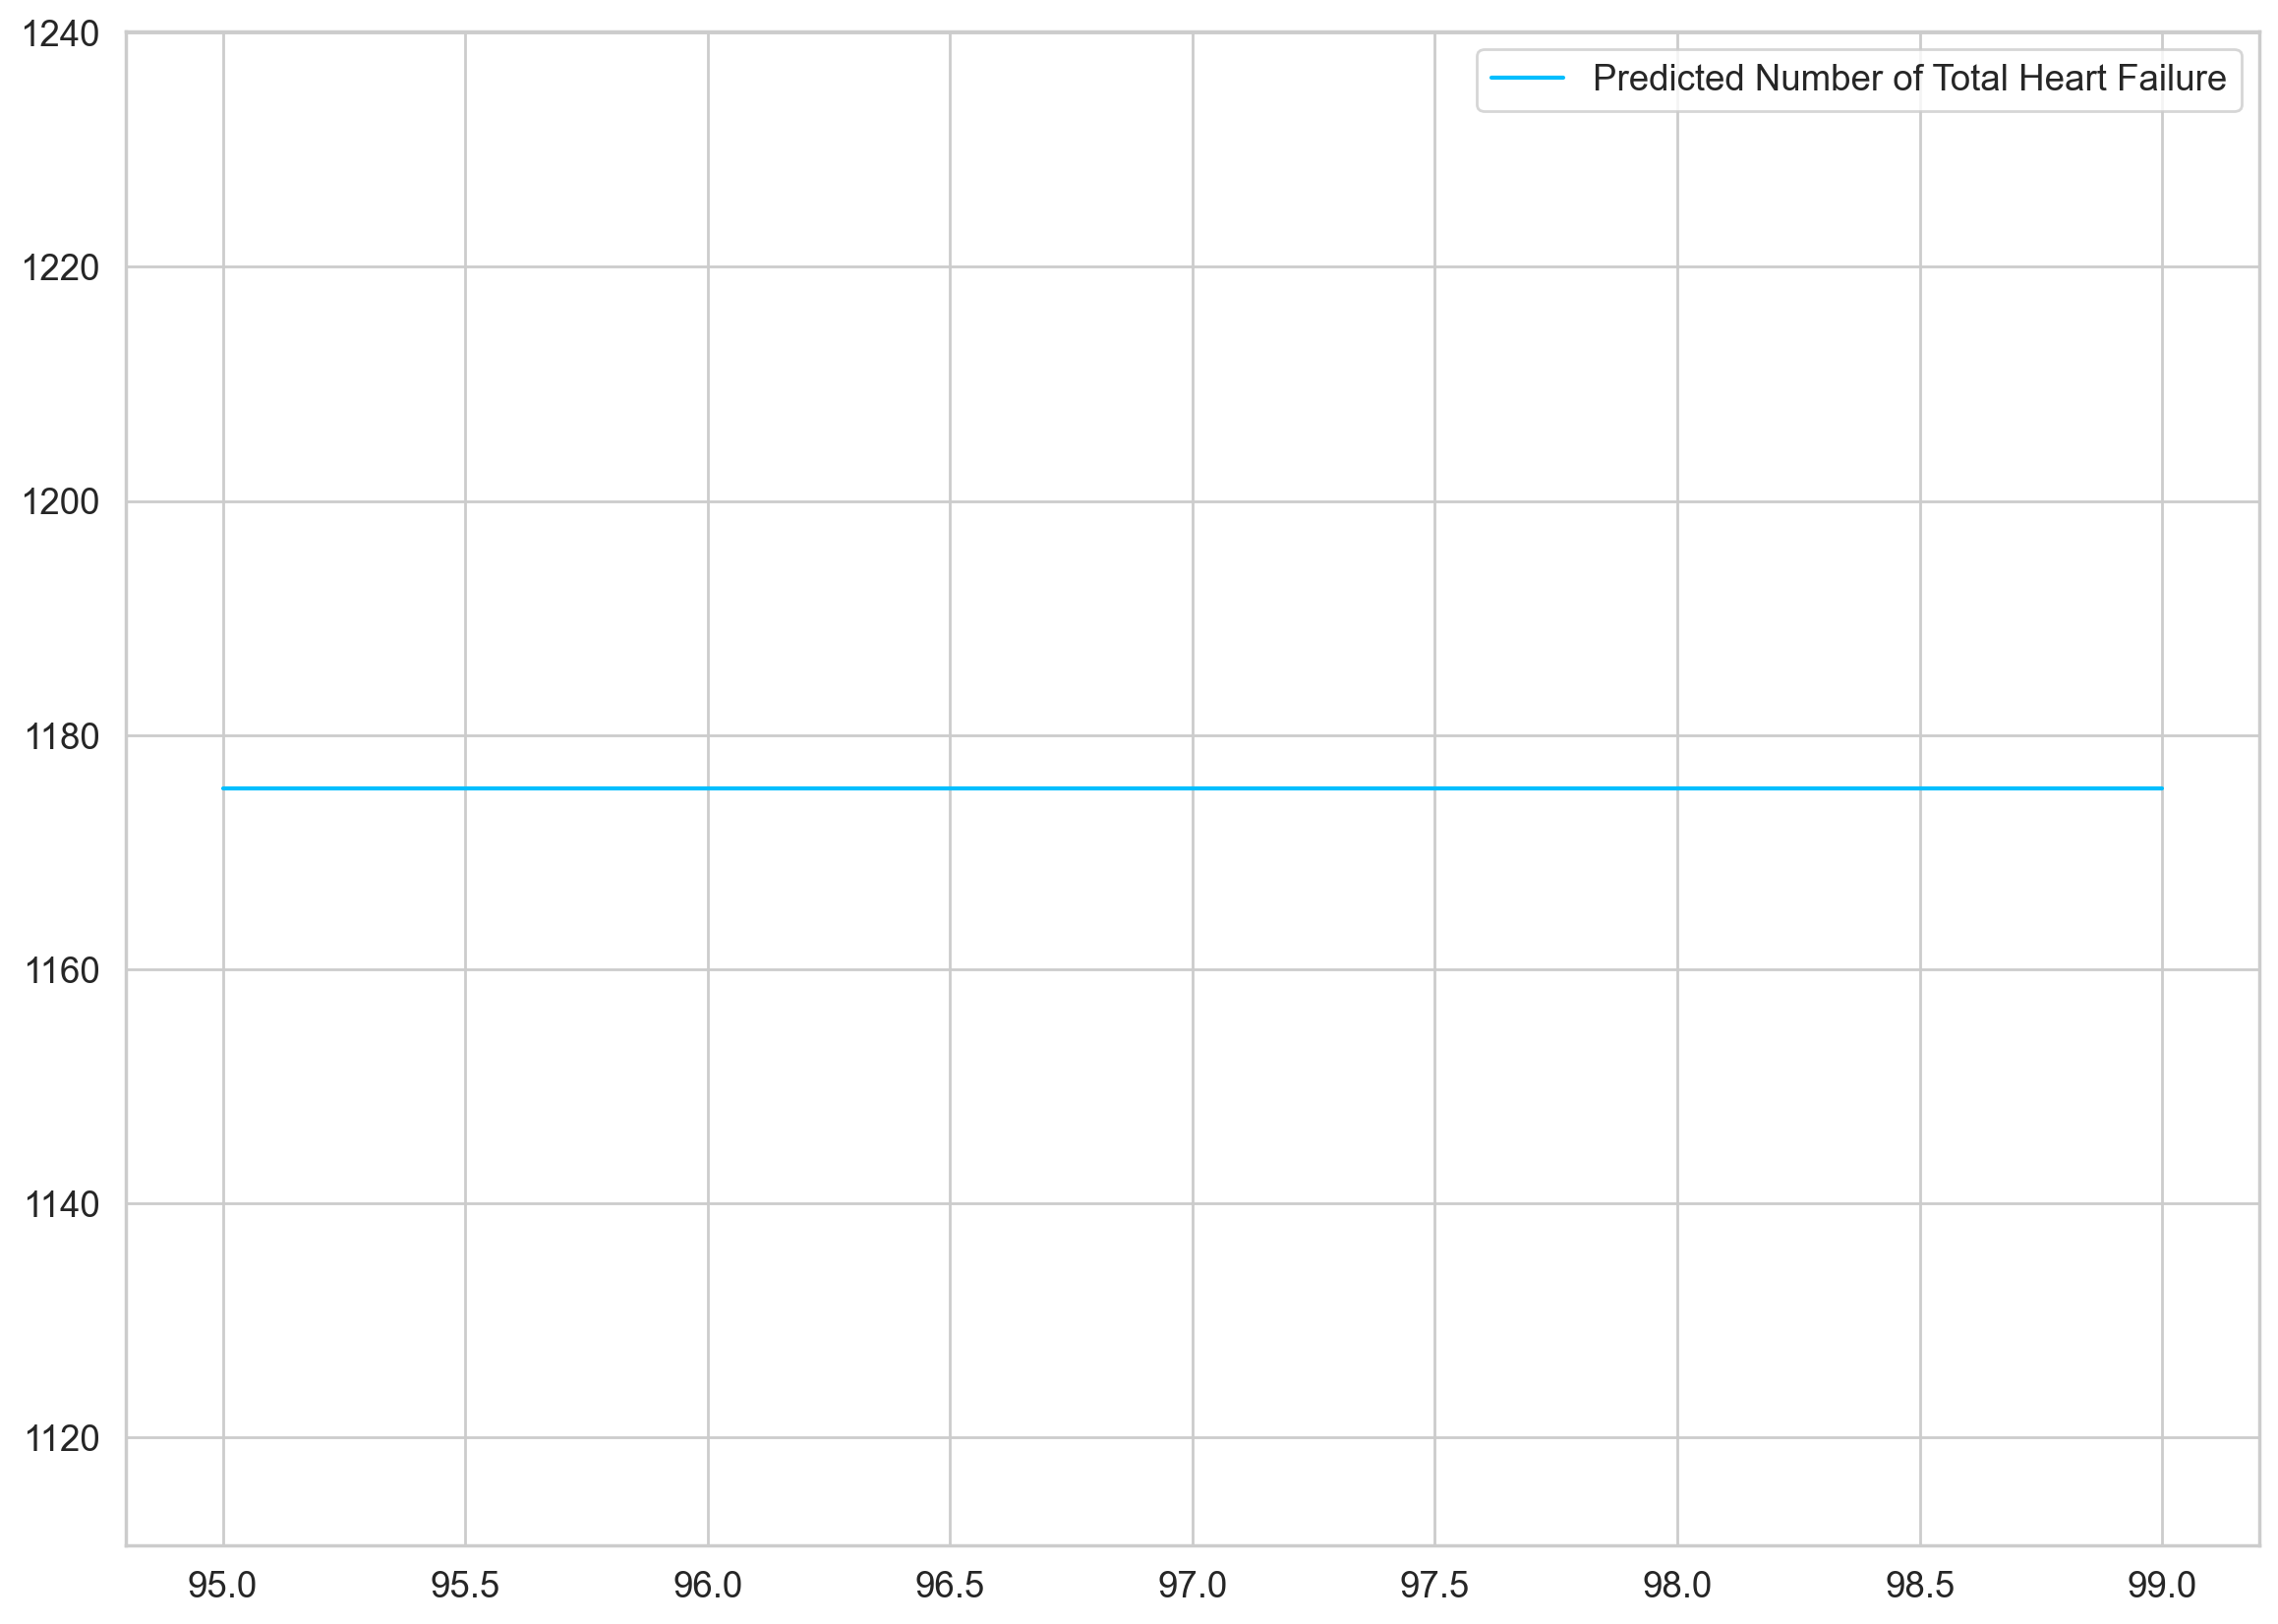

In [152]:
periods=np.zeros(DAYS_TO_PREDICT, dtype = int)
#periods=[]
#y = []
#periods = [periods.append(i) for i in range(all_age[-1],all_age[-1]+DAYS_TO_PREDICT)]
#periods.append(i) for i in range(all_age[-1],all_age[-1]+DAYS_TO_PREDICT)
periods=np.arange(all_age[-1],all_age[-1]+DAYS_TO_PREDICT,1)
#all_age.extend(periods)
plt.plot(periods,predicted_cases, label='Predicted Number of Total Heart Failure')
plt.legend();

Now we can use all the data to plot the results:

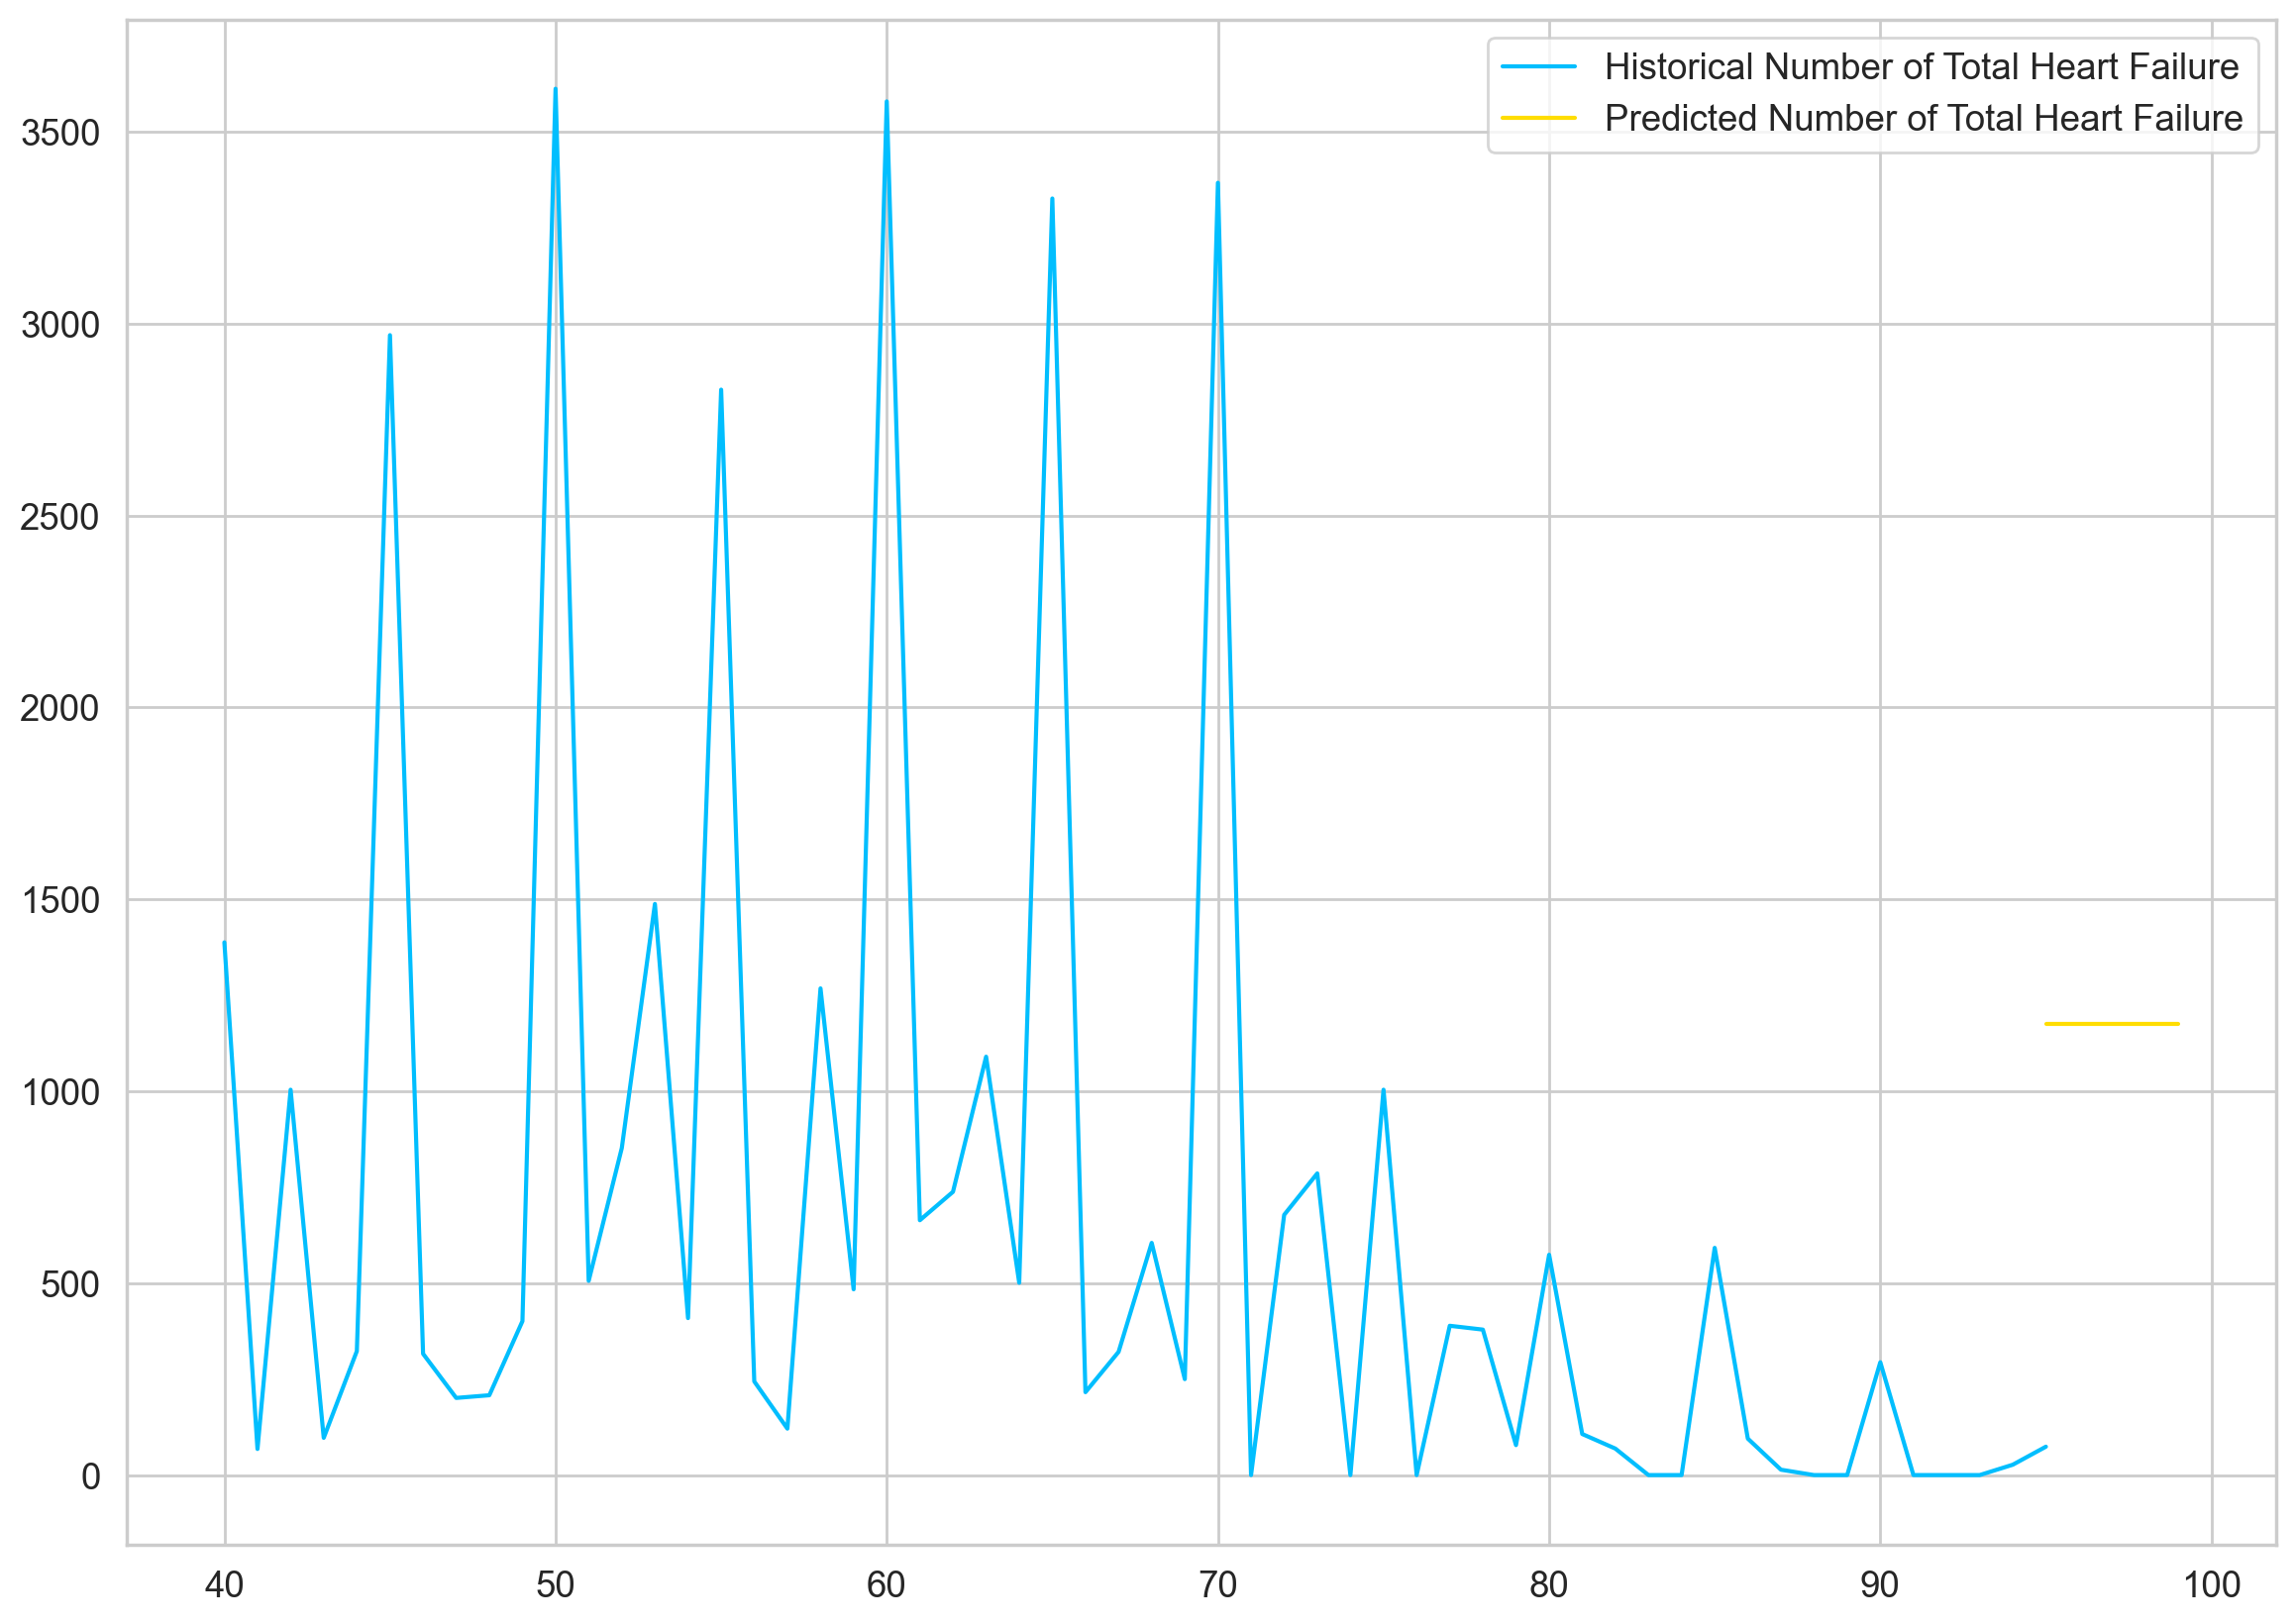

In [153]:
plt.plot(all_age,age_wise_sum, label='Historical Number of Total Heart Failure')
plt.plot(periods,predicted_cases, label='Predicted Number of Total Heart Failure')
plt.legend();

Our model thinks that things will level off. Note that the more you go into the future, the more you shouldn't trust your model predictions.

[False False False False False]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
Confusion matrix : 
 [[0 0]
 [5 0]]


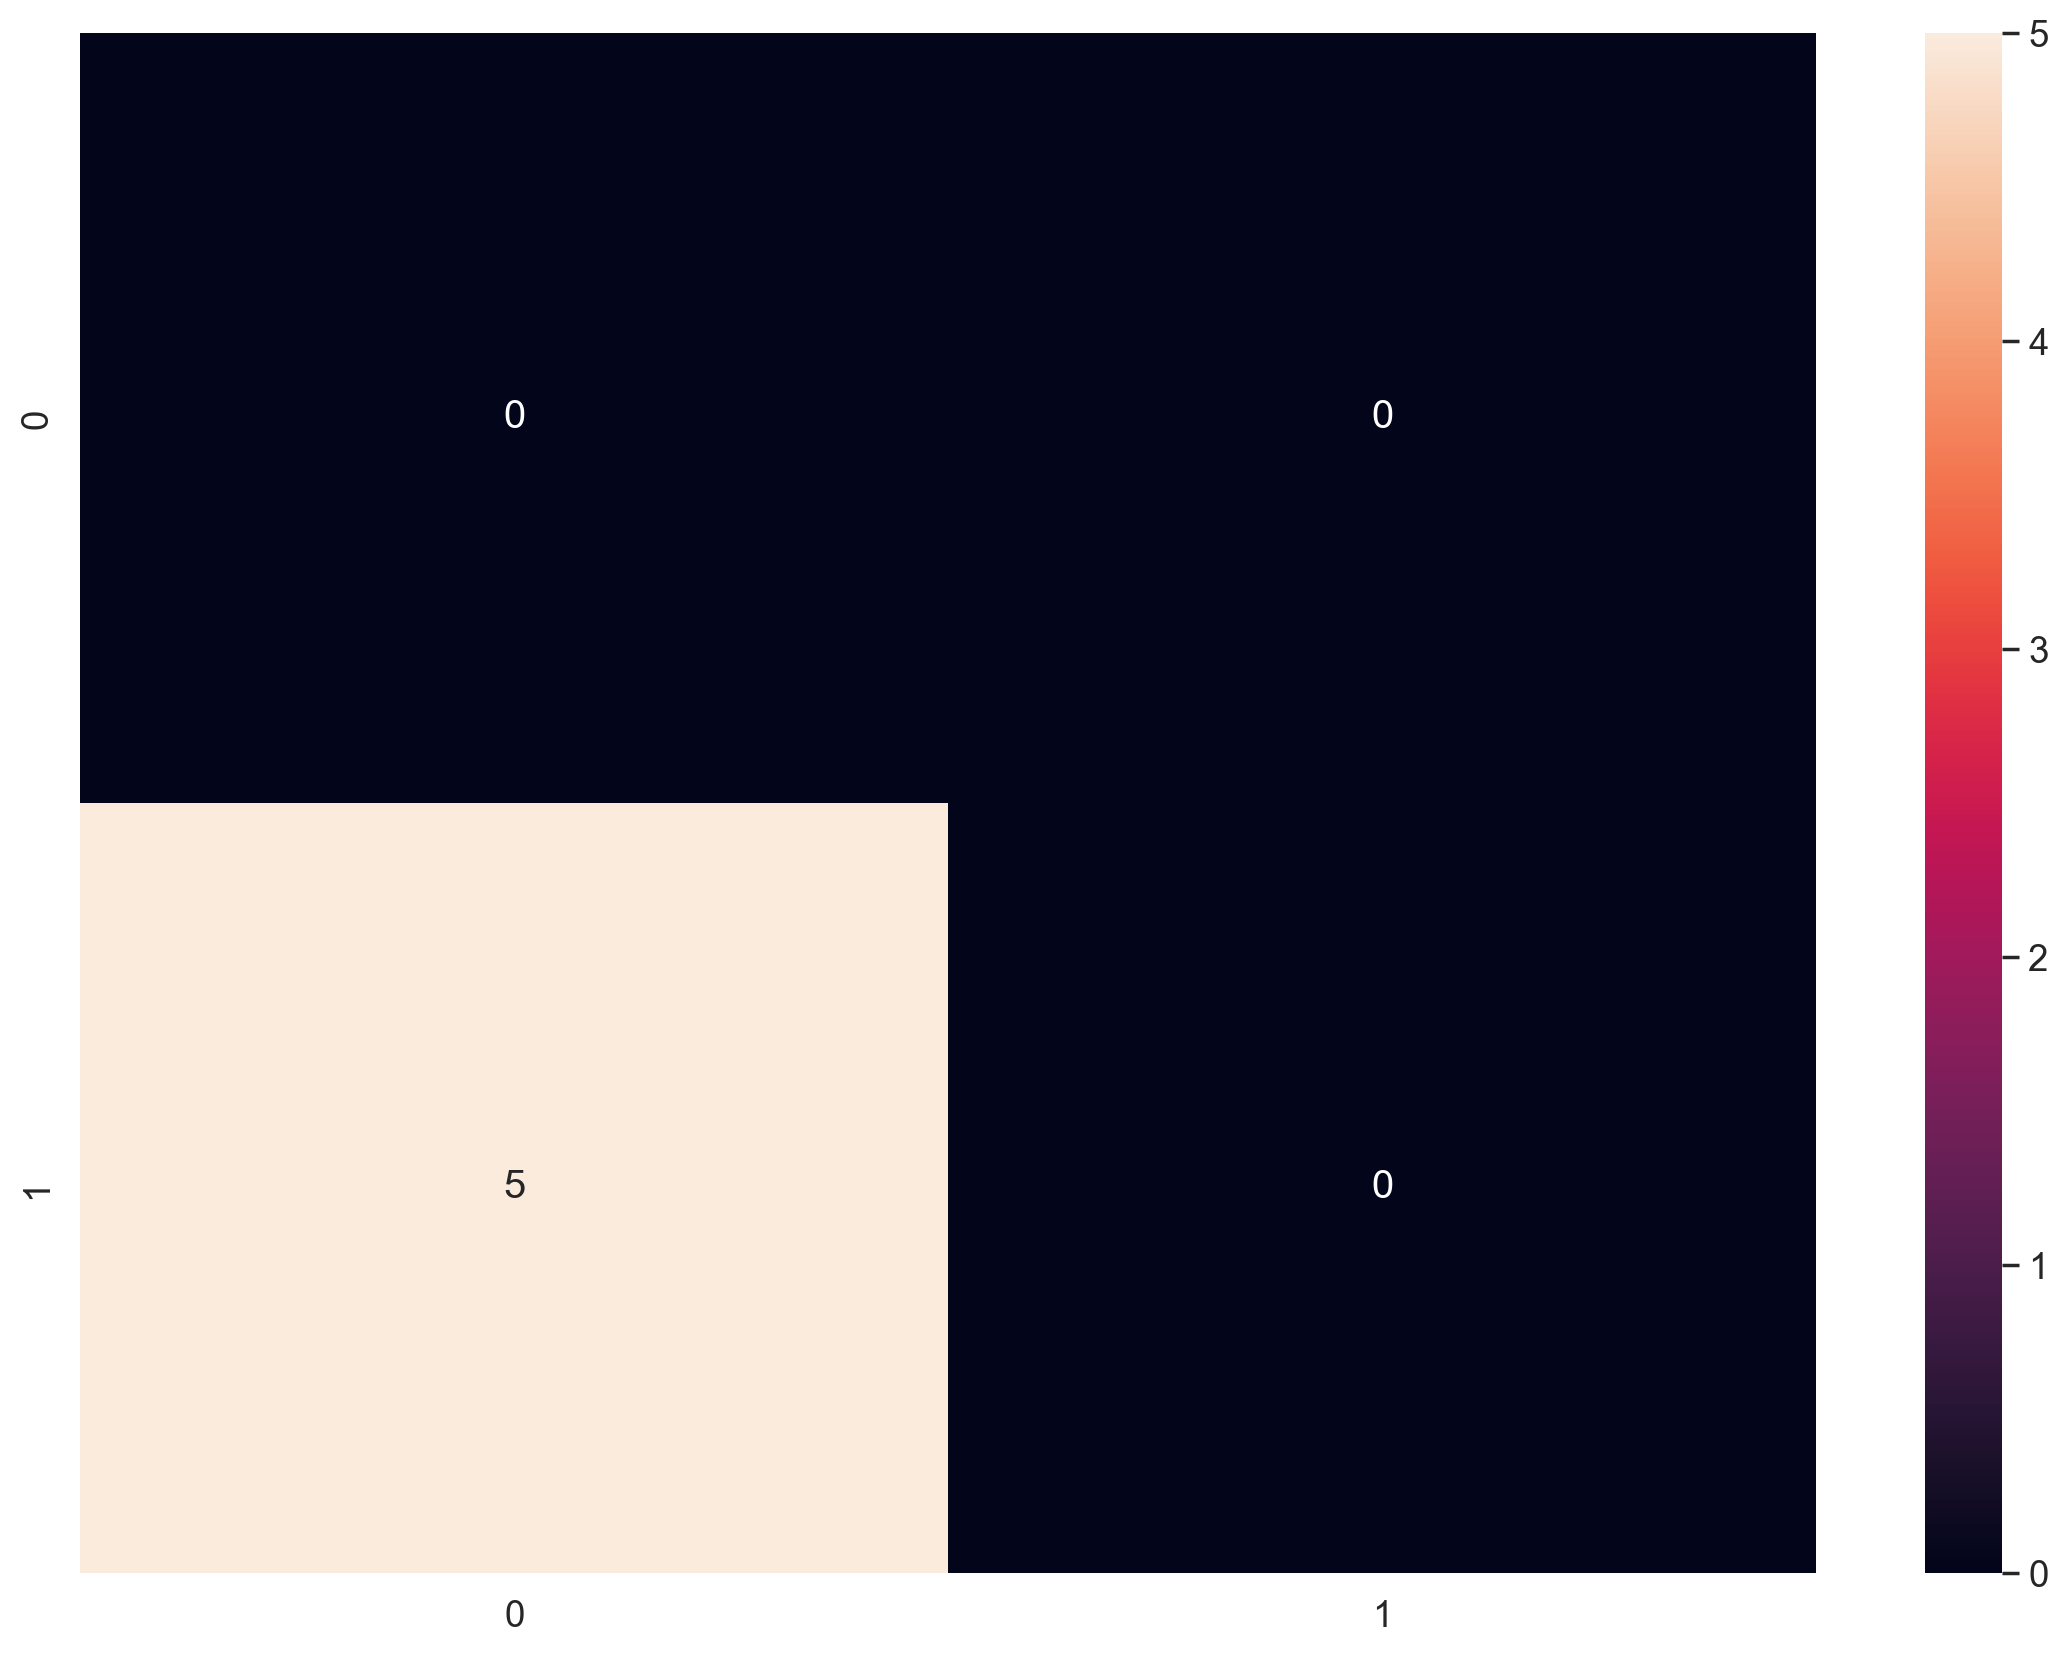

In [154]:
#bin_true_cases=(true_cases<=200)
bin_predicted_cases=(predicted_cases<=200)
print(bin_predicted_cases)
print(bin_true_cases)
matrix = confusion_matrix(bin_true_cases[:5],bin_predicted_cases[:])
print('Confusion matrix : \n',matrix)
sns.heatmap(matrix, annot=True)
plt.show()

## Conclusion

Well done! You learned how to use PyTorch to create a Recurrent Neural Network that works with Time Series data. The model performance is not that great, but this is expected, given the small amounts of data.

- [Run the complete notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1nQYJq1f7f4R0yeZOzQ9rBKgk00AfLoS0)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

The problem of predicting daily Covid-19 cases is a hard one. We're amidst an outbreak, and there's more to be done. Hopefully, everything will be back to normal after some time.

## References

- [Sequence Models PyTorch Tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)
- [LSTM for time series prediction](https://towardsdatascience.com/lstm-for-time-series-prediction-de8aeb26f2ca)
- [Time Series Prediction using LSTM with PyTorch in Python](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/)
- [Stateful LSTM in Keras](https://philipperemy.github.io/keras-stateful-lstm/)
- [LSTMs for Time Series in PyTorch](https://www.jessicayung.com/lstms-for-time-series-in-pytorch/)
- [Novel Coronavirus (COVID-19) Cases, provided by JHU CSSE](https://github.com/CSSEGISandData/COVID-19)
- [covid-19-analysis](https://github.com/AaronWard/covid-19-analysis)
- [How does Coronavirus compare to Ebola, SARS, etc?](https://www.youtube.com/watch?v=6dDD2tHWWnU)
- [Worldometer COVID-19 Coronavirus Outbreak](https://www.worldometers.info/coronavirus/)
- [How contagious is the Wuhan Coronavirus? (Ro)](https://www.worldometers.info/coronavirus/#repro)
- [Systemic Risk of Pandemic via Novel Pathogens - Coronavirus: A Note](https://www.academia.edu/41743064/Systemic_Risk_of_Pandemic_via_Novel_Pathogens_-_Coronavirus_A_Note)
- [Statistical Consequences of Fat Tails: Real World Preasymptotics, Epistemology, and Applications](https://www.researchers.one/article/2020-01-21)
